
## captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task

Captions need to describe: what is plotted and what is interesting about it


PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.






## respect coding standards
*The [following PEP8 rules](https://docs.google.com/document/d/1-XnKK4xRBA5FXOBa4p0Z4in7qfVyk4CutjSMEX-jpTQ/edit?usp=sharing) are now required*

Points will be taken off if they are violated

## problem statement

** An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

# data acquisition

## download, move data to $PUIDATA, and read data in 
make sure you limit the PLUTO dataset to Manhattan, The entire NYC PLUTO dataset is huge!

In [73]:
from __future__ import print_function
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandas.io.json import json_normalize
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
import json
import requests, zipfile, StringIO
import os
import numpy as np
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import shapely
import choroplethNYC as cp
import statsmodels.formula.api as smf

In [4]:
#Set Environmental PUIDATA
puidata = os.getenv("PUIDATA")
if not puidata or puidata == '/nfshome/sjs909/PUIdata':
    puidata = '/nfshome/sjs909/PUIDATA'

os.environ["PUIDATA"] = puidata
os.environ["PUIDATA"]


'/nfshome/sjs909/PUIDATA'

In [5]:
nrg = pd.read_csv(os.getenv("PUIDATA") + 
                  "/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2014__Data_for_Calendar_Year_2013.csv")

In [176]:
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919.0
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200.0
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000.0


In [2]:
'''# Tried doing it through api...data was different and didn't easily work with scatterplot
url = "https://data.cityofnewyork.us/resource/m46j-75iy.json"

r = requests.get(url)
data = r.json()
nrg1 = json_normalize(data)'''

In [3]:
'''nrg1.head()'''

,automatic_water_benchmarking_eligible,bbls_co_reported,bin,borough,census_tract,co_reported_bbl_status,community_board,community_council,direct_ghg_emissions_mtco2e,dof_benchmarking_submission_status,...,reported_property_floor_area_building_s_ft,reported_water_method,site_eui_kbtu_ft2,source_eui_kbtu_ft2,street_name,street_number,total_ghg_emissions_mtco2e,weather_normalized_site_eui_kbtu_ft2,weather_normalized_source_eui_kbtu_ft2,zip_code
0,N/A,1000410001,NaN,Manhattan,NaN,NaN,NaN,NaN,NaN,BBL not valid,...,918919,N/A,NaN,NaN,NaN,NaN,NaN,Not Available,Not Available,NaN
1,Yes,NaN,NaN,Queens,NaN,NaN,NaN,NaN,NaN,No Submission Matched to BBL,...,#N/A,None,NaN,NaN,108 STREET,63-10,NaN,NaN,NaN,11375
2,N/A,2027620097,NaN,Bronx,NaN,NaN,NaN,NaN,NaN,BBL not valid,...,64200,N/A,NaN,NaN,NaN,NaN,NaN,Not Available,Not Available,NaN
3,No,NaN,1012266,Manhattan,99,NaN,4,3,NaN,No Submission Matched to BBL,...,#N/A,None,NaN,NaN,11 AVENUE,201,NaN,NaN,NaN,10001
4,N/A,2048300034,NaN,Bronx,NaN,NaN,NaN,NaN,NaN,Not on Covered Buildings List,...,50000,None,NaN,NaN,NaN,NaN,NaN,Not Available,Not Available,NaN


In [7]:
# Import MN Shapefile from PLUTO dataset
zip_file_url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip'
r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(StringIO.StringIO(r.content))
z.extractall("/nfshome/sjs909/PUIDATA/MNMapPLUTO")

In [8]:
bsize = GeoDataFrame.from_file(os.getenv("PUIDATA") + "/MNMapPLUTO/MNMapPLUTO.shp")

In [9]:
bsize.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_area,SHAPE_len,geometry
0,MN,1545,52,108,138,4000,02,5,10028,E022,...,0.000000e+00,None,1,None,None,18V1,0,2867.154705,260.428942,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,MN,723,7501,104,93,6000,02,3,10001,E003,...,1.007230e+09,11/30/2006,1,None,None,18V1,7,10907.639931,417.764545,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,MN,1680,48,111,170,5000,04,8,10029,E091,...,0.000000e+00,None,1,1,1,18V1,0,2665.033424,256.893308,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,MN,1385,32,108,130,2003,02,4,10021,E039,...,0.000000e+00,None,1,None,None,18V1,0,15302.920914,505.033271,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,MN,1197,27,107,169,5000,03,6,10024,E074,...,0.000000e+00,None,1,None,None,18V1,0,4374.612456,295.652483,"POLYGON ((992273.6849975586 224863.4904174805,..."


## exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

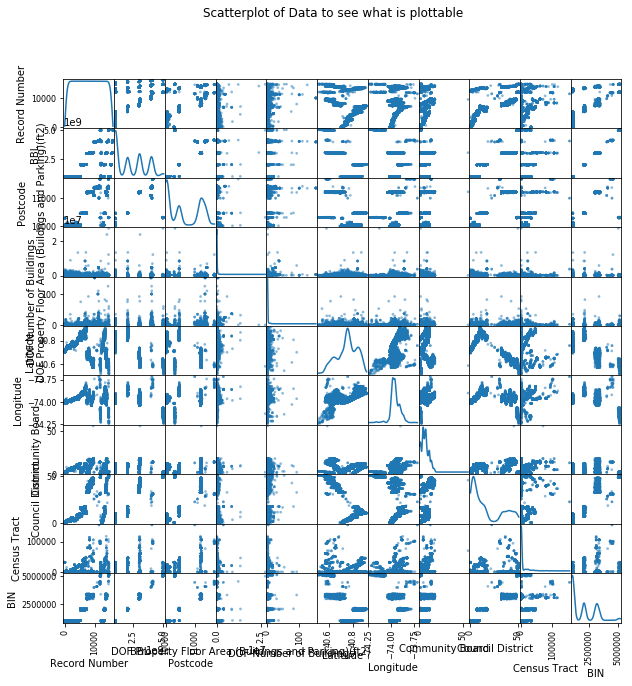

In [10]:
sfig= pd.plotting.scatter_matrix(nrg, s=30, figsize=(10, 10), diagonal='kde')
plt.suptitle('Scatterplot of Data to see what is plottable')

Figure 1: Here we see the correlation between variables...however it is a bit of a mess due to all the axis labels that might not be pertinent to analyze. We see that only 11 out of 32 columns can be plotted with numbers, the rest are probably not numeric. 

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

## data cleaning and aggregation 
### checking the content of the datasets


clean up columns I am not using: for my solution, I will keep  BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

### remove what you do not need

In [44]:
nrg.columns

Index([u'Record Number', u'BBL', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Postcode',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)', u'water',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings',
       u'Latitude', u'Longitude', u'Community Board', u'Council District',
       u'Census Tract', u'BIN', u'NTA'],
      dtype='object')

In [11]:
# rename  u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)' was causing errors
nrg.rename(columns={"Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)" : "water"},inplace=True)

In [12]:
nrg.drop([u'Record Number', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Postcode',
       u'DOF Benchmarking Submission Status',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)', u'water',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings',
       u'Latitude', u'Longitude', u'Community Board', u'Council District',
       u'Census Tract', u'BIN', u'NTA'], axis = 1, inplace=True)

In [9]:
bsize.columns.sort_values()

Index(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot',
       'BBL', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR',
       'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID',
       'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea',
       'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMap', 'Tract201

In [13]:
bsize.drop(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot',
       'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR',
       'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID',
       'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea',
       'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMap', 'Tract2010', 'Version',
       'XCoord', 'YCoord', 'YearAlter1', 'YearAlter2', 'ZMCode',
       'ZipCode', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'ZoneMap'],axis = 1, inplace = True)

In [14]:
#leave
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [15]:
#leave
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


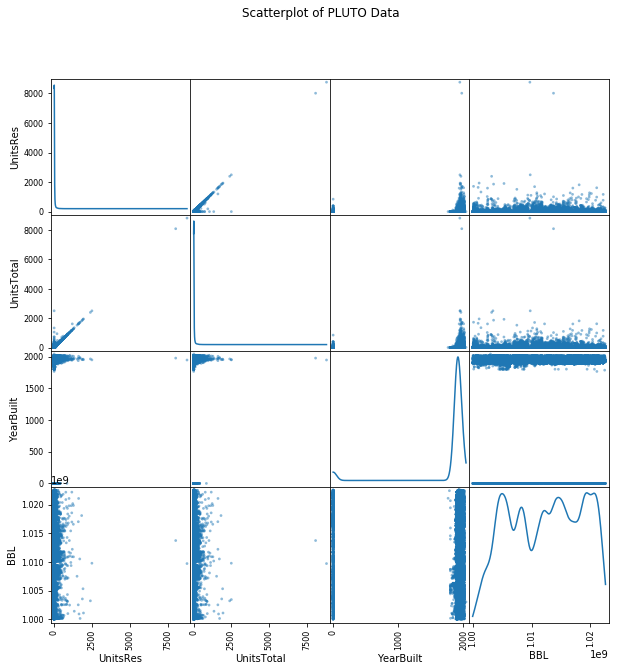

In [16]:
#leave (dont try this scatter matrix before cleaning the data, it will take a while)
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')
plt.suptitle('Scatterplot of PLUTO Data')

Figure 2: Here we see a condensed version of the scatterplot for PLUTO Data. Some patterns we see are where there are clusters of data, such as year built and total units. A few linear patterns that make sense logically, such as units total and units residents. BBL stands for NYC Borough, Block, and Lot...where we can see the numbering system in an interesting way.

## converting  the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


In [20]:
nrg = nrg[nrg.columns].convert_objects(convert_numeric=True)

In [22]:
bsize = bsize[bsize.columns].convert_objects(convert_numeric=True)

In [27]:
nrg.columns

Index([u'BBL', u'Site EUI(kBtu/ft2)',
       u'Reported Property Floor Area (Building(s)) (ft²)'],
      dtype='object')

In [26]:
bsize.columns

Index([u'UnitsRes', u'UnitsTotal', u'YearBuilt', u'BBL', u'geometry'], dtype='object')

In [38]:
 bsize.YearBuilt.astype(float)[:10]

0    1920.0
1    1914.0
2    1910.0
3    1928.0
4    1900.0
5    1910.0
6    1920.0
7    1915.0
8    1915.0
9    1900.0
Name: YearBuilt, dtype: float64

In [39]:
bsize.UnitsRes.astype(float)[:10], bsize.UnitsTotal.astype(float)[:10]

(0    16.0
 1    50.0
 2    10.0
 3    29.0
 4    26.0
 5     2.0
 6     0.0
 7     0.0
 8    30.0
 9    10.0
 Name: UnitsRes, dtype: float64, 0    18.0
 1    50.0
 2    10.0
 3    32.0
 4    26.0
 5     3.0
 6     8.0
 7     2.0
 8    30.0
 9    10.0
 Name: UnitsTotal, dtype: float64)

In [41]:
nrg['BBL'].astype(float)[:10]

0    1.000410e+09
1    4.021460e+09
2    2.027620e+09
3    1.006700e+09
4    2.048300e+09
5    2.006120e+09
6    3.050770e+09
7    3.065710e+09
8    4.004490e+09
9    3.072240e+09
Name: BBL, dtype: float64

In [42]:
nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)[:10]

0    918919.0
1         NaN
2     64200.0
3         NaN
4     50000.0
5     61800.0
6    102198.0
7     46620.0
8         NaN
9     54029.0
Name: Reported Property Floor Area (Building(s)) (ft²), dtype: float64

In [35]:
##check that your conversion worked: e.g.
print( nrg['Site EUI(kBtu/ft2)'].astype(float)[:10] + bsize.BBL.astype(float)[:10])

#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want

#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
dtype: float64
0    1.001331e+09
1             NaN
2    2.027686e+09
3             NaN
4    2.048352e+09
5    2.006184e+09
6    3.050874e+09
7    3.065759e+09
8             NaN
9    3.072296e+09
dtype: float64


In [45]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [47]:
len(nrg['Site EUI(kBtu/ft2)'])

16170

In [50]:
##check that your conversion worked: e.g.
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.00


 ## merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [55]:
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


In [54]:
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919.0
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200.0
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000.0


In [57]:
#leave
#merge in a geodataframe for mapping, and if you want in a regular DF for analysis (more portable)
bblnrgdataGPD = bsize.merge(nrg, on='BBL', how = 'outer')
bblnrgdata = nrg.merge(bsize, on='BBL', how = 'outer')

In [68]:
bblnrgdataGPD.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),logarea,lognrg
0,16.0,18.0,1920.0,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,...",NaN,NaN,NaN,NaN
1,50.0,50.0,1914.0,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0,11.470477,4.229749
2,10.0,10.0,1910.0,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,...",NaN,NaN,NaN,NaN
3,29.0,32.0,1928.0,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0,12.240421,4.470495
4,26.0,26.0,1900.0,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,...",NaN,NaN,NaN,NaN


In [65]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry
0,1.000410e+09,NaN,918919.0,NaN,NaN,NaN,NaN
1,4.021460e+09,NaN,NaN,NaN,NaN,NaN,NaN
2,2.027620e+09,NaN,64200.0,NaN,NaN,NaN,NaN
3,2.027620e+09,112.1,55000.0,NaN,NaN,NaN,NaN
4,1.006700e+09,NaN,NaN,0.0,1.0,1987.0,"POLYGON ((982544.9470214844 212642.966796875, ..."


# Plot the data as a choropleth for the 2 quantities of interest: unit area and energy consumed energy

In [161]:
# drop the na
bblnrgdataGPD.dropna(inplace=True)

In [67]:
# Take log of unitstotal and nrg
bblnrgdataGPD['logarea'] =  np.log(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)'])
bblnrgdataGPD['lognrg'] = np.log(bblnrgdataGPD['Site EUI(kBtu/ft2)'])

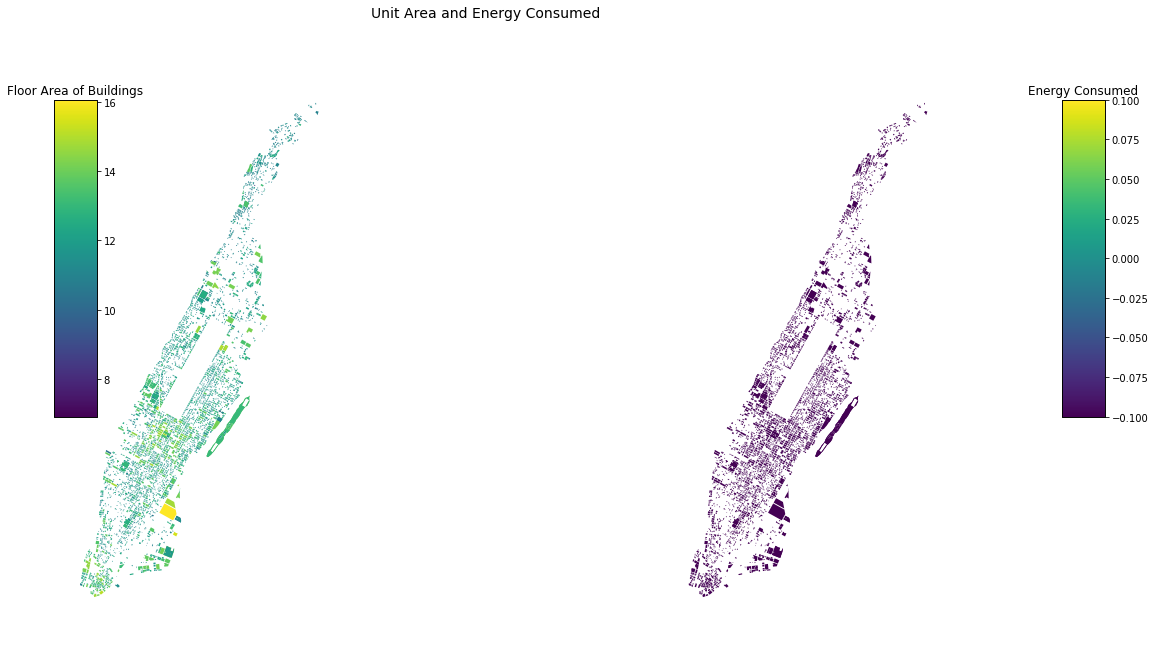

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
cp.choroplethNYC(bblnrgdataGPD, column='logarea', ax = axes[0],cmap="viridis")
plt.title('Floor Area of Buildings')
cp.choroplethNYC(bblnrgdataGPD, column='lognrg', ax = axes[1],cmap="viridis", side=True)
plt.title('Energy Consumed')
fig.suptitle("Unit Area and Energy Consumed", fontsize=14)


Fig 3. Here is a choropleth of total floor area of buildings as well as the total energy consumed. It is curious to see the one spot in Stuyvesant Town where there is large area but low energy consumption. Perhaps this is due to the design of high vertical buildings with uninhabited greenspace built by Robert Moses. Elsewhere, we see a relatively homogenous spread of small square ft and low energy consumption.

# feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.
Create a total energy column from the columns you have.
Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

In [177]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry,nrg
19,1.013110e+09,125.4,330000.0,0.0,56.0,1977.0,"POLYGON ((993141.1744384766 216172.3948364258,...",41382000.0
203,1.010140e+09,154.9,841709.0,0.0,2.0,1999.0,"POLYGON ((987726.6307983398 214846.9885864258,...",130380724.1
258,1.007660e+09,122.3,59468.0,0.0,8.0,1912.0,"POLYGON ((984350.5375976562 209226.3930053711,...",7272936.4
259,1.008150e+09,117.0,364000.0,0.0,64.0,1954.0,"POLYGON ((988118.5700073242 213939.774597168, ...",42588000.0
268,1.005050e+09,82.1,235370.0,0.0,24.0,1926.0,"POLYGON ((982849.6038208008 203886.2427978516,...",19323877.0


In [164]:
## multiplying area by energy/area to get total energy per building
bblnrgdata['nrg'] = bblnrgdata[\
    'Reported Property Floor Area (Building(s)) (ft²)'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)

In [165]:
bblnrgdata['nrg'].describe()

count    4.624000e+03
mean     4.291699e+07
std      4.119175e+08
min      5.344000e+03
25%      5.872002e+06
50%      9.171283e+06
75%      1.788265e+07
max      9.926784e+09
Name: nrg, dtype: float64

In [167]:
# Remove outliers in nrg
bblnrgdata = bblnrgdata[bblnrgdata['nrg'] < 1e11]

In [168]:
# Remove outliers in number of units
#bblnrgdata = 
bblnrgdata = bblnrgdata[bblnrgdata['UnitsTotal'] < 1000]

In [178]:
bblnrgdata.nrg.min()

5344.0

In [179]:
bblnrgdata.nrg.max()

9926784000.0

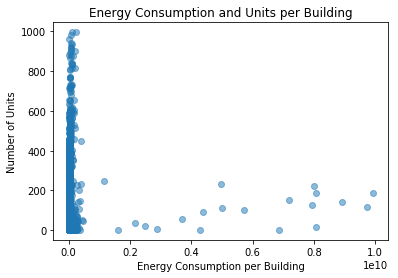

In [169]:
plt.scatter(bblnrgdata['nrg'],bblnrgdata['UnitsTotal'], alpha = .5 )
plt.xlabel('Energy Consumption per Building')
plt.ylabel('Number of Units')
plt.title('Energy Consumption and Units per Building')

Fig 4. Here we see the relationship between Energy Consumption and units per building. Although most points are clustered by a very low amount of energy consumption, we see a pattern of a linear increase in energy consumption as the units increases. 

minimum building energy value 5344.0
maximum building energy value 350145188000.0


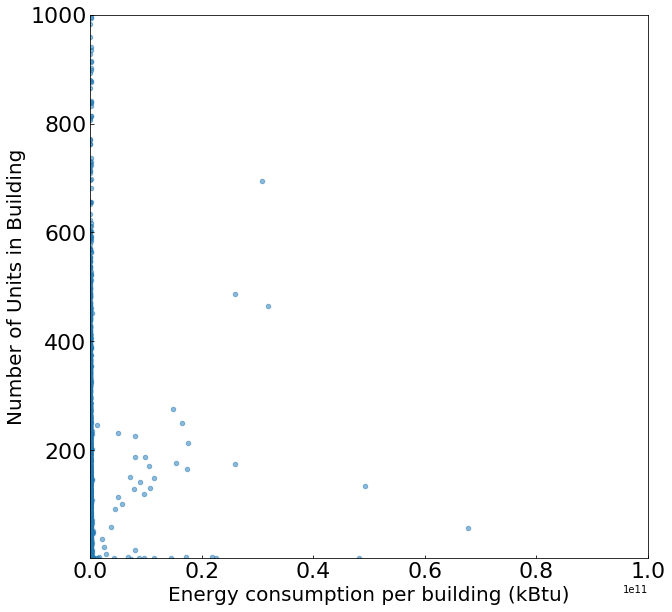

In [36]:
## multiplying area by energy/area to get total energy per building
bblnrgdata['nrg'] = bblnrgdata[\
    'Reported Property Floor Area'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
...

# The magic of log scales!
**Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year. **

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

In in log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5 (basically log10 gives you the number of 0's in its argument, or the *order of magnitude*)





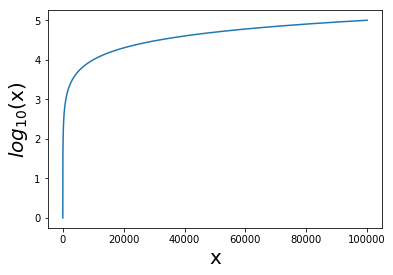

In [125]:
plt.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
plt.xlabel("x", fontsize=20)
plt.ylabel(r"$log_{10}$(x)", fontsize=20)

The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale. 

Another property of the logarithm is that if the relationship between data is a power law (y = x^a) then the relationship between the log of the variables is linear! And we know that modeling things with linear models is easy!

	log_10(x^y) = y ∙ log_10(x)
    
And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything: 

    energy between (1000,1e10)

    units between (1,1000)

You can cut the axis to visualize the data like this, **but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.**

to visualize the data in log scale you can use the dataframe plotting method with the argument 

    loglog=True


In [147]:
# Limit axis values from 1000,1e10
bblnrgdata['nrg'].describe()

count    5.010000e+03
mean     1.441022e+08
std      1.837616e+09
min      0.000000e+00
25%      5.855188e+06
50%      9.301289e+06
75%      1.868108e+07
max      6.779388e+10
Name: nrg, dtype: float64

In [170]:
bblnrgdata = bblnrgdata[bblnrgdata['nrg']  > 1000]

In [171]:
bblnrgdata = bblnrgdata[bblnrgdata['nrg']  < 1e10]

In [172]:
bblnrgdata = bblnrgdata[bblnrgdata['UnitsTotal'] > 1]

In [173]:
bblnrgdata = bblnrgdata[bblnrgdata['UnitsTotal'] < 1000]

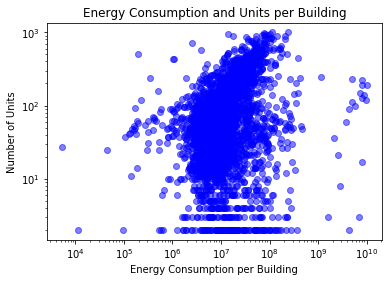

In [174]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(bblnrgdata['nrg'],bblnrgdata['UnitsTotal'], c='blue',alpha = .5)
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Energy Consumption per Building')
plt.ylabel('Number of Units')
plt.title('Energy Consumption and Units per Building')

Using log we see a much more dynamic spread of the information. We see a central tendency of energy consumption around 1 x 10^7 no matter the number of units. However there is spread where a few buildings consume a lot more energy, but do not seem to depend on the number of units becaus they are scattered vertically. 

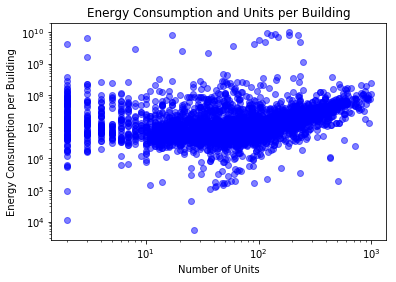

In [180]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(bblnrgdata['UnitsTotal'],bblnrgdata['nrg'], c='blue',alpha = .5)
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Number of Units')
plt.ylabel('Energy Consumption per Building')
plt.title('Energy Consumption and Units per Building')

Here we see a central tendency of energy consumption distributed throughout the number of units. There is a slight upward curve towards the tail end that would suggest when we increase the number of units above 25, there is a trend of higher energy consumption. However there are also several points where there is a less amount of units with a very high energy consumption occuring. Perhaps this is due to poor insulation and energy efficency of older buidlings. 

# Fit the data with a line in log space:  

**make sure you print the summary and plot the data and the model**
figure out how to print the summary

In [225]:
x = bblnrgdata['UnitsTotal']
y = bblnrgdata['nrg']

logx, logy = np.log(x), np.log(y)

p = np.polyfit(logx, logy, 1)
y_fit = np.exp(np.polyval(p, logx))

In [226]:
results = smf.OLS(logy, logx).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nrg   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                 5.862e+04
Date:                Tue, 27 Nov 2018   Prob (F-statistic):               0.00
Time:                        11:41:46   Log-Likelihood:                -13400.
No. Observations:                4624   AIC:                         2.680e+04
Df Residuals:                    4623   BIC:                         2.681e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
UnitsTotal     3.6499      0.015    242.124      0.000       3.620       3.679
==============================================================================
Omnibus:                      830.445   Durbin-Watson:                   1.352
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1485.931
Skew:                           1.138   Prob(JB):                         0.00
Kurtosis:                       4.592   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

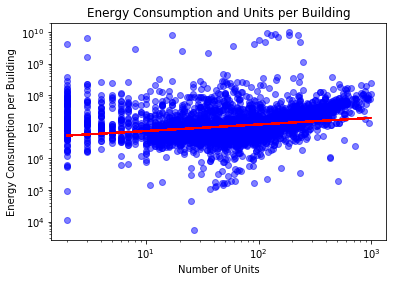

In [206]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(bblnrgdata['UnitsTotal'],bblnrgdata['nrg'], c='blue',alpha = .5)
ax.plot(x, y_fit, 'r-')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Number of Units')
plt.ylabel('Energy Consumption per Building')
plt.title('Energy Consumption and Units per Building')

Here we see a slight increase in energy conumption as the number of units increases. The line fits our data pretty well, with a high r-squared of .92, this means that 92 percent of the data can be explained by our model.

In [233]:
y = bblnrgdata['UnitsTotal']
x = bblnrgdata['nrg']

logx, logy = np.log(x), np.log(y)

p = np.polyfit(logx, logy, 1)
y_fit = np.exp(np.polyval(p, logx))

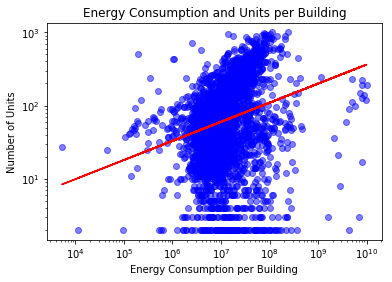

In [217]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(bblnrgdata['nrg'],bblnrgdata['UnitsTotal'], c='blue',alpha = .5)
ax.plot(x, y_fit, 'r-')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Energy Consumption per Building')
plt.ylabel('Number of Units')
plt.title('Energy Consumption and Units per Building')

Here we see the apparent slope of energy consumption increasing steeply as the number of units increases. The slope is probably very affected by the central amalgam of points located in the middle of energy consumption. It does not necessarily fit these points in a vertical fashion, probably due to the points outside of this cluster. 

In [234]:
results = smf.OLS(logy, logx).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                 5.862e+04
Date:                Tue, 27 Nov 2018   Prob (F-statistic):               0.00
Time:                        11:43:59   Log-Likelihood:                -7237.5
No. Observations:                4624   AIC:                         1.448e+04
Df Residuals:                    4623   BIC:                         1.448e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
nrg            0.2540      0.001    242.124      0.000       0.252       0.256
==============================================================================
Omnibus:                      796.662   Durbin-Watson:                   1.457
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1391.500
Skew:                          -1.108   Prob(JB):                    6.91e-303
Kurtosis:                       4.519   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model NRG as a linear function of number of units in the building 

The more units there are, the more energy consumption occurs because that infers more rooms to heat/cool and more space for energy to escape through insulation and require even more energy. Therefore units are the independent variable and energy consumption is dependent. 

However, I will indulge myself and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

### Units vs Energy

In [250]:
y = bblnrgdata['nrg']
x = bblnrgdata['UnitsTotal']

logx, logy = np.log(x), np.log(y)
OLS = smf.ols(formula='logy ~ logx', data=bblnrgdata).fit()
# must sort dataframe before plotting the line

bblnrgdata.sort_values(by='UnitsTotal', inplace = True)
OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logy   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     265.0
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           5.57e-58
Time:                        12:41:48   Log-Likelihood:                -6711.1
No. Observations:                4624   AIC:                         1.343e+04
Df Residuals:                    4622   BIC:                         1.344e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.3414      0.055    280.699      0.000      15.234      15.449
logx           0.2078      0.013     16.279      0.000       0.183       0.233
==============================================================================
Omnibus:                     1304.227   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12405.006
Skew:                           1.068   Prob(JB):                         0.00
Kurtosis:                      10.734   Cond. No.                         16.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [238]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry,nrg
13961,1.012830e+09,139.1,1587872.0,0.0,2.0,1958.0,"POLYGON ((991122.832824707 214696.257019043, 9...",220872995.2
6108,1.019630e+09,67.2,125000.0,0.0,2.0,2013.0,"POLYGON ((995912.4349975586 234511.4130249023,...",8400000.0
6107,1.019630e+09,53.1,139392.0,0.0,2.0,2013.0,"POLYGON ((995912.4349975586 234511.4130249023,...",7401715.2
5133,1.012760e+09,92.8,163743.0,0.0,2.0,1971.0,"POLYGON ((989673.8043823242 213670.3706054688,...",15195350.4
2107,1.010760e+09,187.1,50207.0,0.0,2.0,1946.0,"POLYGON ((985603.6395874023 217752.6538085938,...",9393729.7


In [ ]:
y = bblnrgdata['UnitsTotal']
x = bblnrgdata['nrg']

logx, logy = np.log(x), np.log(y)

p = np.polyfit(logx, logy, 1)
y_fit = np.exp(np.polyval(p, logx))

fig = plt.figure()
ax = plt.gca()
ax.scatter(bblnrgdata['nrg'],bblnrgdata['UnitsTotal'], c='blue',alpha = .5)
ax.plot(x, y_fit, 'r-')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Energy Consumption per Building')
plt.ylabel('Number of Units')
plt.title('Energy Consumption and Units per Building')

### Energy against Units

# Second degree polynomial fit

model the data with a slightly more complex model: 
    
    y = ax*x + bx + c, 

instead of 
        
    y = bx + c
    
**make sure you print the summary and plot the data and the model**


In [272]:
# must sort values before
bblnrgdata.sort_values(by='UnitsTotal', inplace = True)

x = bblnrgdata['UnitsTotal']
y = bblnrgdata['nrg']

logx, logy = np.log(x), np.log(y)

p = np.polyfit(logx, logy, 2)
y_fit = np.exp(np.polyval(p, logx))

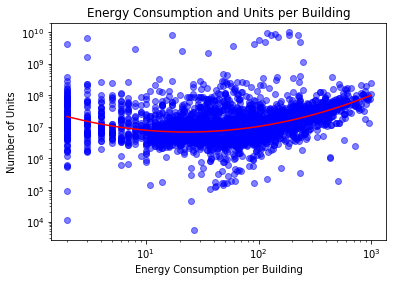

In [273]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(bblnrgdata['UnitsTotal'],bblnrgdata['nrg'], c='blue',alpha = .5)
ax.plot(x, y_fit, 'r-')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Energy Consumption per Building')
plt.ylabel('Number of Units')
plt.title('Energy Consumption and Units per Building')

Here we see the apparent slope of energy consumption increasing steeply as the number of units increases. The slope is probably very affected by the central amalgam of points located in the middle of energy consumption. It does not necessarily fit these points in a vertical fashion, probably due to the points outside of this cluster. 

In [274]:
results = smf.OLS(logy, logx**2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nrg   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                 2.072e+04
Date:                Tue, 27 Nov 2018   Prob (F-statistic):               0.00
Time:                        13:26:01   Log-Likelihood:                -15514.
No. Observations:                4624   AIC:                         3.103e+04
Df Residuals:                    4623   BIC:                         3.104e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
UnitsTotal     0.7182      0.005    143.951      0.000       0.708       0.728
==============================================================================
Omnibus:                        3.781   Durbin-Watson:                   0.037
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                3.822
Skew:                          -0.047   Prob(JB):                        0.148
Kurtosis:                       3.105   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [267]:
# must sort values before plotting
bblnrgdata.sort_values(by='nrg', inplace = True)

y = bblnrgdata['UnitsTotal']
x = bblnrgdata['nrg']

logx, logy = np.log(x), np.log(y)

p = np.polyfit(logx, logy, 2)
y_fit = np.exp(np.polyval(p, logx))

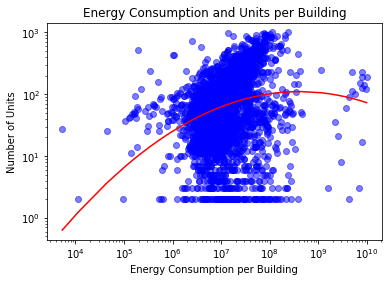

In [268]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(bblnrgdata['nrg'],bblnrgdata['UnitsTotal'], c='blue',alpha = .5)
ax.plot(x, y_fit, 'r-')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Energy Consumption per Building')
plt.ylabel('Number of Units')
plt.title('Energy Consumption and Units per Building')

In [270]:
results = smf.OLS(logy, logx**2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                 5.468e+04
Date:                Tue, 27 Nov 2018   Prob (F-statistic):               0.00
Time:                        13:25:34   Log-Likelihood:                -7386.3
No. Observations:                4624   AIC:                         1.477e+04
Df Residuals:                    4623   BIC:                         1.478e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
nrg            0.0155   6.61e-05    233.839      0.000       0.015       0.016
==============================================================================
Omnibus:                     1262.774   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3197.613
Skew:                          -1.486   Prob(JB):                         0.00
Kurtosis:                       5.787   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logNrg   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     595.3
Date:                Sun, 18 Nov 2018   Prob (F-statistic):          6.30e-229
Time:                        21:56:58   Log-Likelihood:                -2441.3
No. Observations:                4300   AIC:                             4889.
Df Residuals:                    4297   BIC:                             4908.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.9473      0.112     71.211      0.000       7.729       8.166
logUnits            -1.5293      0.119    -12.866      0.000      -1.762      -1.296
I(logUnits ** 2)     0.5312      0.031     17.162      0.000       0.471       0.592
==============================================================================
Omnibus:                     2341.343   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52336.972
Skew:                           2.124   Prob(JB):                         0.00
Kurtosis:                      19.555   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

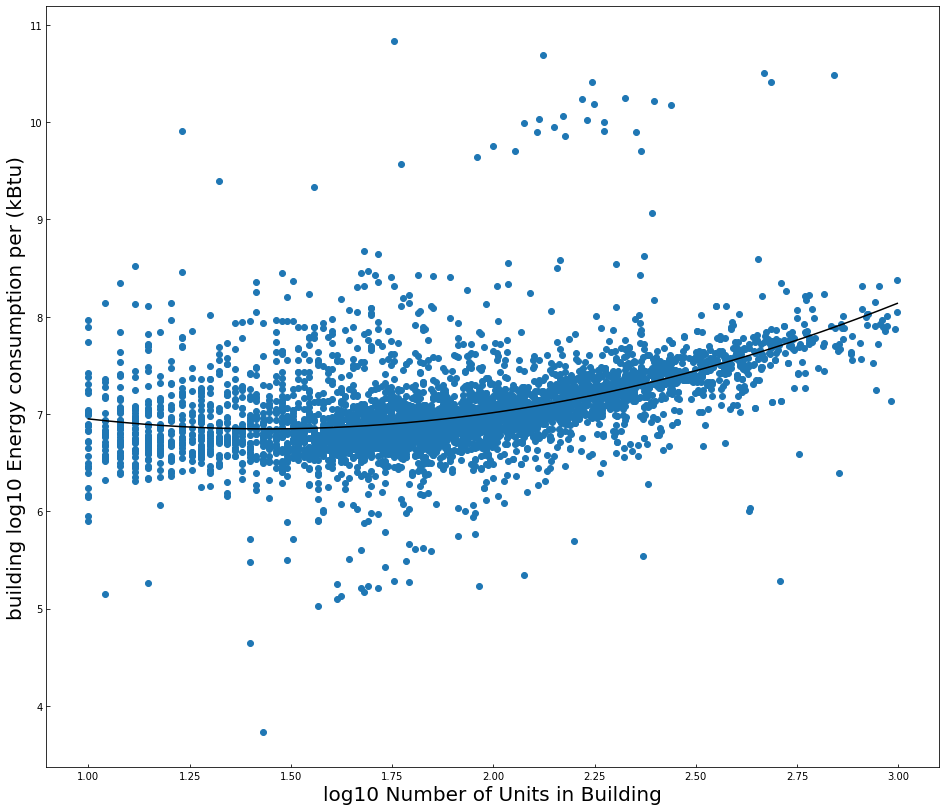

In [119]:
#I find the easiest way to use the formula package is to use a dataframe 
#with the quantities that are not linear already calculated

# you can do it whichever way is easy for you
bblnrgdataCut['logNrg']  = ...
bblnrgdataCut['logUnits']  = ...


Figure 8: ...

# calculate the chi square and likelihood of your model

## Define a chisquare function

In [275]:
#leave
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    for i in len(range(data[i])):
        x = ((model.predict(data[i])-data[i])**2)/data[i] 
    return sum(x)


In [287]:
my_list = ((results.predict(bblnrgdata['nrg'])-bblnrgdata['nrg'])**2)/bblnrgdata['nrg']
sum(my_list)

15759496555.006138

## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [69]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#errors on the measured quantities
bblnrgdataCut['errorsnrg'] = ...

# better WOULD BE to calculate each error and add in quadrature: sqrt(1/A + 1/B) which becomes
#errorsnrg = np.sqrt(1.0 / bblnrgdataCut['Reported Property Floor Area'] + 1.0 / bblnrgdataCut['Site EUI(kBtu/ft2)'])
#but this leads to insane error values (insanely small)

## Assume count statistics in the number of units as well
bblnrgdataCut['errorsunits'] = ...


## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

The largest error bar is for


,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area,nrg,errorsnrg,errorsunits
3313,27,27,1909,1.019900e+09,0.1,53440.0,5344.0,4.342945,0.08358


//anaconda/envs/GEOP/lib/python3.6/site-packages/matplotlib/_constrained_layout.py:171: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
  warnings.warn('There are no gridspecs with layoutboxes. '


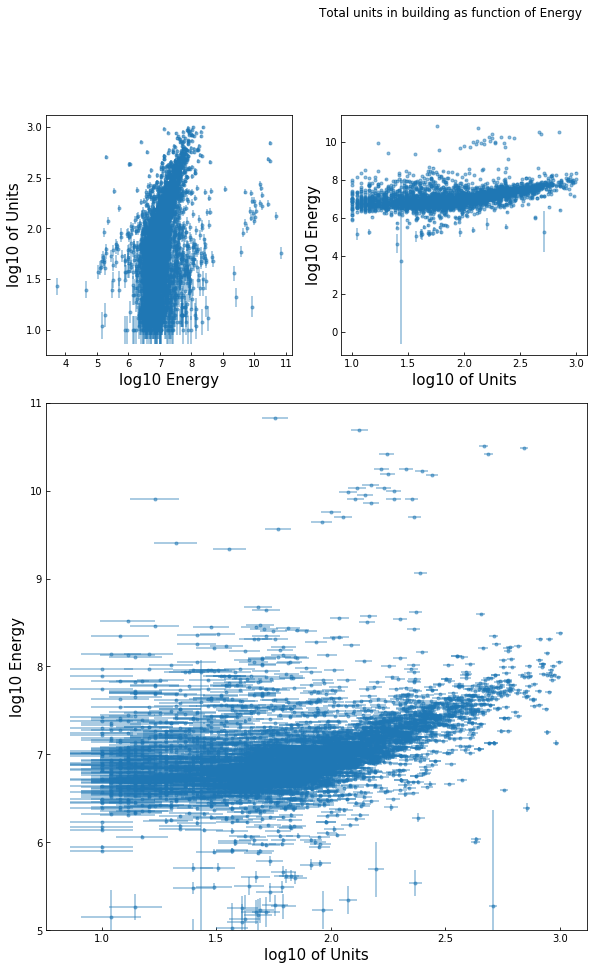

In [113]:
#I could also include errors for number of units
fig2 = plt.figure(constrained_layout=True, figsize=(15,15))

gs1 = gridspec.GridSpec(3, 3, figure=fig2)
gs1.update(left=0.68, right=0.68, wspace=0.2)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.errorbar(np.log10(bblnrgdataCut.nrg), np.log10(bblnrgdataCut.UnitsTotal), 
            yerr=bblnrgdataCut.errorsunits, fmt='.',
            alpha=0.5)
ax1.set_ylabel("log10 of Units", fontsize=15)
ax1.set_xlabel("log10 Energy", fontsize=15)
pl.suptitle("Total units in building as function of Energy")


ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
ax2.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errorsnrg, fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)

ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errorsnrg,
           xerr=bblnrgdataCut.errorsunits, alpha=0.5, fmt='.')
ax4.set_xlabel("log10 of Units", fontsize=15)
ax4.set_ylabel("log10 Energy", fontsize=15)
ax4.set_ylim(5,11)

print ("The largest error bar is for")
bblnrgdataCut[bblnrgdataCut.errorsnrg == bblnrgdataCut.errorsnrg.max()]


Figure 7: The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

## Add the errors and calculate the chi square


### calculate the degrees of freedom of this model

In [ ]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = ...
print ("degrees of freedom:" , dof)

In [78]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict()) / 
        float(dof)))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict(), 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))


Units vs Energy residuals (no errors include): 0.13
Units vs Energy chi square per DOF w independent variable error only: 49254526.95
Units vs Energy chi square per DOF : 101.70


In [79]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict()) / dof))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict(), 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))


Energy vs Units residuals (no errors include): 0.19
Energy vs Units chi square per DOF w independent variable error only: 776699531.02
Energy vs Units chi square per DOF : 115.15


### Compare the models using the  chi square:
discuss

If the result of the units vs energy surprises you plot the influence plot for the model. Except the default statsmodels influence plot is a bit of a mess, cause so many points have high leverage, and thus high influence, that the labels cover the span of the plot and make it useless. One could relatively easily engineered one's own influence plot, but instead for the purpose of this discussion comparing the units vs energy with the energy vs units influence plot is sufficient to show how many more points with high **leverage** are in the first plot than in the second - look at the axis range! What is happening is that the distribution of points along the exogenous variable is much better suited to a line fit in the energy vs units plot. You want a large spread in the exogenous variable. In the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit. 

Figure 10: ...

# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


LR = ...
**reject / not reject...**

## EC 1 Plotting the likelihood surface (assuming gaussian statistics)

when you assume Gaussian statistics the log likelihood is the chi square, so you can plot the chi square from the function you created earlier!

* choose a reasonable range of a, b, and c for your parameters. 
* calculate the chisquare for each value in the range: this can be done in a nested for loop
* save the value of the chi square and plot it as a surface

in pylab you can plot surfaces with pl.imshow()


### creating a function that returns the likelihood value on a grid
We already have the function! If we assume a Gaussian distribution then the likelihood is the chi square (not exactly, but it is a linear function of the chi squared, which means that maximizing the log likelihood is the same as minimizing the chi square).
this is a brute force minimization, which is escruciatingly slow and should not be done due to its inefficiency, but it is a transparent code that allows you to see what it means to maximize the likelihood surface (which is equivalent to minimizing the sum of the residuals squared, or the chi squared if errors are used)

### calculating and plotting the loglikelihood in a 2D sensible range of values
plot is for 
    - chi square calculated with no errors (i.e. sum of residuals squared)
    - chi squared with errors
    
compare the surfaces

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


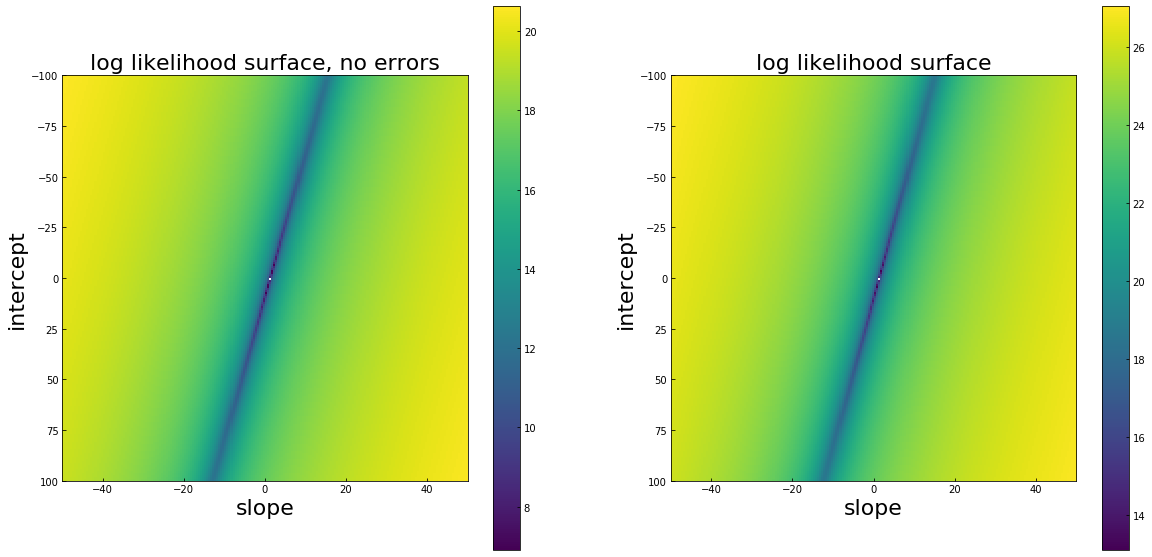

In [124]:
fig = pl.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.set_title ("log likelihood surface, no errors", fontsize = 22)
pl.imshow(np.log(resids_noerror), extent = [-50,50,100,-100], aspect=0.5)
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar()

ax2 = fig.add_subplot(122)
ax2.set_title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(resids), extent = [-50,50,100,-100], aspect=0.5)
ax2.set_xlabel('slope', fontsize = 22)
ax2.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 11: ...

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


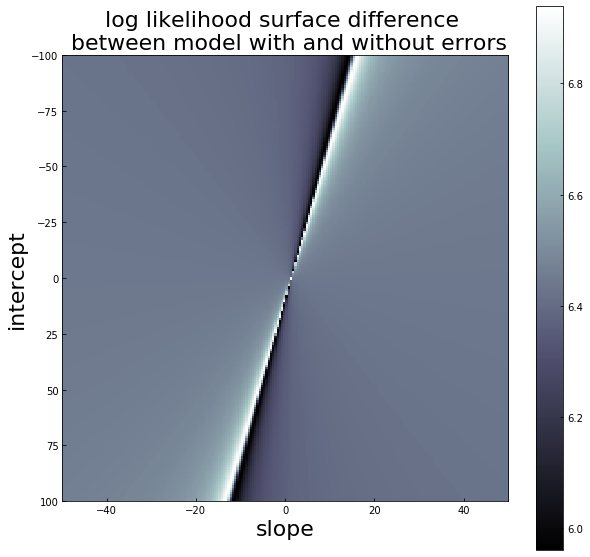

In [125]:
#leave
#plotting the difference between the 2 likelihood surfaces to see if the minimum is in the right place
ax1 = pl.figure(figsize=(10,10)).add_subplot(111)
ax1.set_title ("log likelihood surface difference \n between model with and without errors", fontsize = 22)
pl.imshow(np.abs(np.log(resids) - np.log(resids_noerror)), extent = [-50,50,100,-100], aspect=0.5, cmap='bone')
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 12: ...

# EXTRA CREDIT: a plot of anything related to these data

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda/envs/GEOP/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
//anaconda/envs/GEOP/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


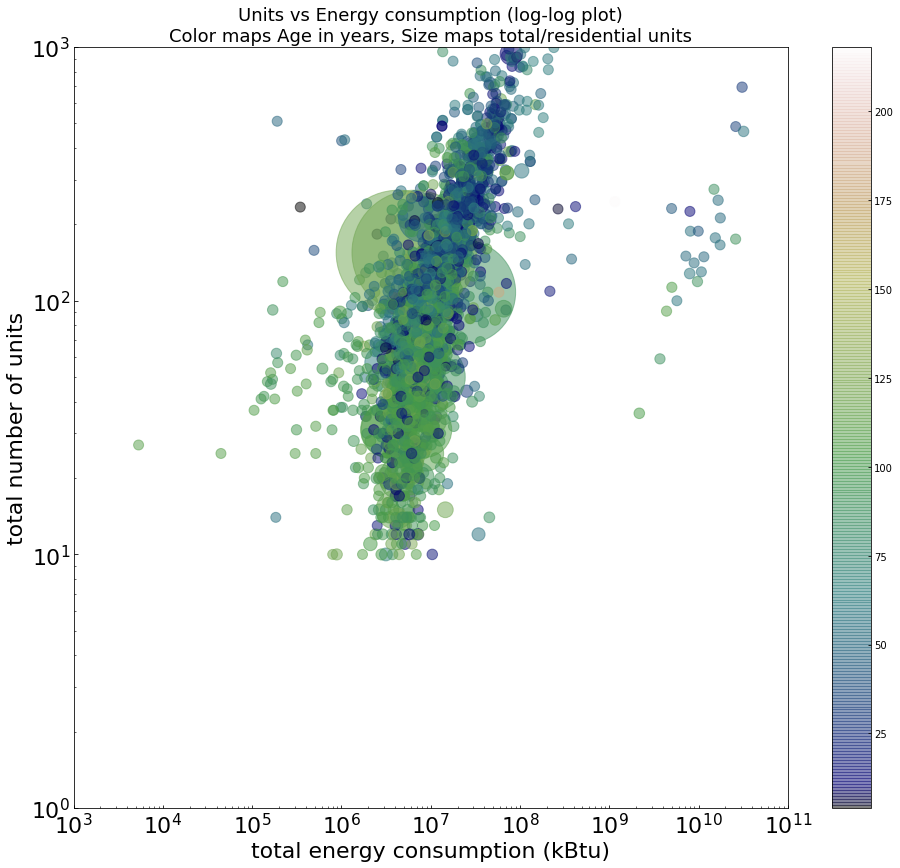

In [126]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
bblnrgdataCut['YearBuilt'][bblnrgdataCut['YearBuilt']<1800]=1800

bblnrgdataCut.plot(kind='scatter', x='nrg', y='UnitsTotal', 
                fontsize=22, colormap='gist_earth', alpha = 0.5, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), ax = ax,
                c= dt.datetime.today().year - bblnrgdataCut['YearBuilt'], 
                s=bblnrgdataCut['UnitsTotal']/bblnrgdataCut['UnitsRes'] * 100)
pl.title('Units vs Energy consumption (log-log plot)\nColor maps Age in years, Size maps total/residential units', 
         fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22);


Figure 13: Plot of Number of Units as a function of energy consumption for all NYC buildings with self reported energy consumption in the Local Law 84 database. The color of each datapoint representes the age: darker colors are buildings of more recent construction. The size of the mark represents the inverse of the fraction of residential units in the building (large datapoints indicate a small fraction of residential units, i.e. a comercial building). 

There is a weak color gradient where younger buildings dominate the higher portion of the plot. This could be interpreted as higher efficiency: at the same energy consumption younger buildings host more people. Or it could be driven by architectural changes: a trend to host the same number of people segregating them in more smaller units.

Aside from a few obvious outliers there is no obvious trend in fraction of residential units with building age, energy, or total number of units